In [1]:
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as pyplot
from matplotlib import cm
import plotly.express as px

import pandas as pd
import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2
print(gpytorch.__version__)

0.3.6


In [2]:
# load data
fe_data = pd.read_csv('C:\\Users\\roberttk\\Desktop\\SLAC_RA\\DATA\\ferroelectric_data\\FE_HZCO_samples_11-17.csv', index_col=0)
fe_data['log(RTA time)'] = np.log(fe_data['RTA time (sec)'])
print(fe_data.head())

   Thickness (nm)  RTA temperature (C)  RTA time (sec)  CeO2 doping  \
1              10                  350              30          4.4   
2              10                  350              60          4.4   
3              10                  350             120          4.4   
4              10                  350             300          4.4   
5              10                  350             600          4.4   

   2Pr (uC/cm2), Pristine state  log(RTA time)  
1                       0.31095       3.401197  
2                       3.05088       4.094345  
3                      11.48724       4.787492  
4                      27.85326       5.703782  
5                           NaN       6.396930  


In [3]:
# plot?...
fig = px.scatter_3d(fe_data, x='RTA temperature (C)', y='log(RTA time)', 
                        z='2Pr (uC/cm2), Pristine state')
fig.update_layout(scene=dict(
                            xaxis=dict(nticks=4, range=[200, 800])
                            # yaxis=dict(range=[0, 500])
                            ),
                   margin=dict(r=20, l=10, b=10, t=10)
                   )
fig.show()

In [4]:
# prep training data
from sklearn.preprocessing import StandardScaler
T_scaler = StandardScaler()

# filter training data 
m1 = fe_data['RTA time (sec)'] == 30
m2 = ~np.isnan(fe_data['2Pr (uC/cm2), Pristine state'])
mask = m1.values & m2.values

train_raw_x = torch.Tensor(fe_data['RTA temperature (C)'][mask].values)
train_raw_y = torch.Tensor(fe_data['2Pr (uC/cm2), Pristine state'][mask].values)

train_y = train_raw_y # (train_raw_y - train_raw_y.mean()) / (train_raw_y.max() - train_raw_y.min())
train_x = train_raw_x #(train_raw_x - train_raw_x.mean()) / (train_raw_x.max() - train_raw_x.min())

In [5]:
def intermediate_plot(f, ax, obs, title):
    ax.plot(train_x, train_y, 'k*')
    ax.plot(test_x, obs.mean.numpy(), 'b')
    lower, upper = obs.confidence_region()


    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_title(title)

In [6]:
test_x = torch.linspace(train_x.min(), train_x.max()+10, 51)
test_raw_x = torch.linspace(train_raw_x.min(), train_raw_x.max(), 51)

In [64]:
# initialize GP model
class GP_1D(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP_1D, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
                                gpytorch.kernels.RBFKernel() )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.Tensor([0.1]))
model = GP_1D(train_x, train_y, likelihood)

model.covar_module.base_kernel.lengthscale = torch.Tensor([50])


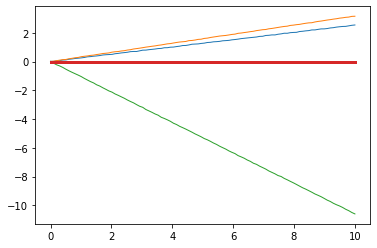

In [63]:
# Plot priors for demonstration purposes

# having significant noise in likelihood will cause prior distributions to also be noisy
blank_likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.Tensor([0.1]))
blank_model = GP_1D(torch.Tensor([0]), torch.Tensor([0]), blank_likelihood)
# blank_model.covar_module.base_kernel.lengthscale = torch.Tensor([40])

# make plots for prior by not training model
# apparently setup of model does some initial training, but no optimization
blank_model.eval()
blank_likelihood.eval()
blank_test_x = torch.linspace(0, 10)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    obs = blank_likelihood(blank_model(blank_test_x))

lower, upper = obs.confidence_region()
# plt.fill_between(blank_test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='confidence')

for i in range(3): # draw samples
    plt.plot(blank_test_x, obs.sample(), lw=1)
plt.plot(blank_test_x, obs.mean, lw=3)

In [55]:
blank_model.covar_module

ScaleKernel(
  (base_kernel): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
    (distance_module): Distance()
  )
  (raw_outputscale_constraint): Positive()
)

Iter 100/1000 - Loss: 63.798  lengthscale1: [[44.597454]]   noise: 0.100
Iter 200/1000 - Loss: 34.309  lengthscale1: [[41.96681]]   noise: 0.100
Iter 300/1000 - Loss: 22.806  lengthscale1: [[40.012066]]   noise: 0.100
Iter 400/1000 - Loss: 17.115  lengthscale1: [[38.453365]]   noise: 0.100
Iter 500/1000 - Loss: 13.949  lengthscale1: [[37.158794]]   noise: 0.100
Iter 600/1000 - Loss: 12.026  lengthscale1: [[36.05404]]   noise: 0.100
Iter 700/1000 - Loss: 10.759  lengthscale1: [[35.09259]]   noise: 0.100
Iter 800/1000 - Loss: 9.864  lengthscale1: [[34.243176]]   noise: 0.100
Iter 900/1000 - Loss: 9.194  lengthscale1: [[33.483593]]   noise: 0.100
Iter 1000/1000 - Loss: 8.669  lengthscale1: [[32.797398]]   noise: 0.100


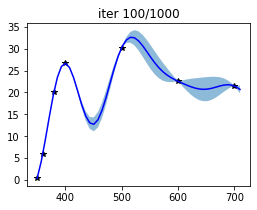

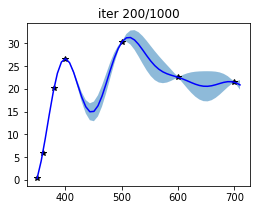

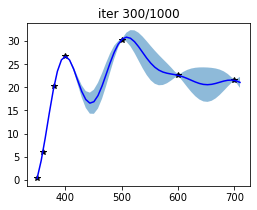

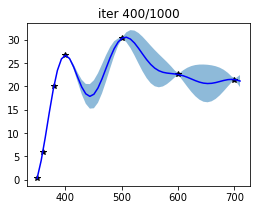

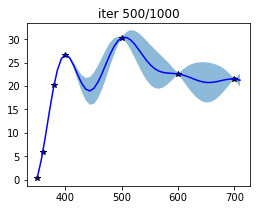

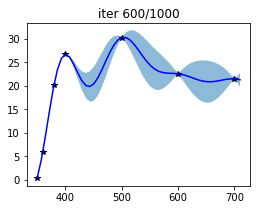

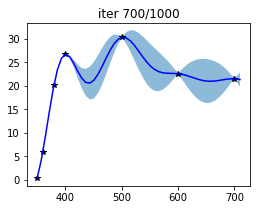

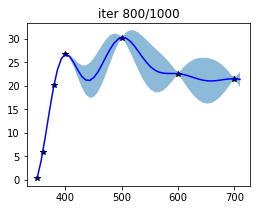

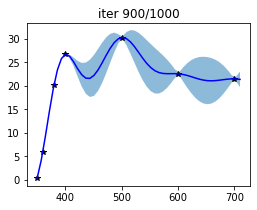

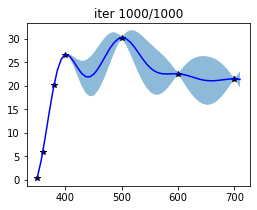

In [20]:
# Training loop
training_iter = 1000

# Place in training mode
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()

    output = model(train_x)

    loss = -mll(output, train_y)
    loss.backward()

    if (i+1) % 100 == 0: 
        print('Iter %d/%d - Loss: %.3f  lengthscale1: %s   noise: %0.3f' % (
        i+1, training_iter, loss.item(), 
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
        model.likelihood.noise.item()
        ))

        # get a quick snapshot of intermediate 
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            obs = likelihood(model(test_x))

            f, ax = plt.subplots(1, 1, figsize=(4,3))
            intermediate_plot(f, ax, obs, f'iter {i+1}/{training_iter}')
        model.train()
        likelihood.train()


    optimizer.step()

In [8]:
# make predictions
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    obs = likelihood(model(test_x))
# print(f'train data: {fe_data["2Pr (uC/cm2), Pristine state"][1]}')
# print(f'observed: {obs.mean}')




Text(0.5, 1.0, 'Mean: ConstantMean, Covariance: RBFKernel, 1000 iters')

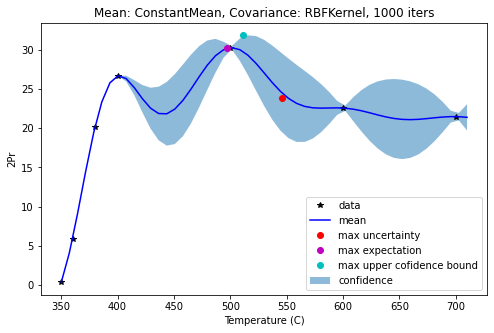

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

# mean
ax.plot(train_x, train_y, 'k*', label='data')
ax.plot(test_x, obs.mean.numpy(), 'b', label='mean')
lower, upper = obs.confidence_region()
ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='confidence')

# grab and plot metrics
max_var_i = np.argmax(obs.variance).item()
max_ex_i = np.argmax(obs.mean).item()
max_ucb_i = np.argmax(upper)

ax.plot(test_raw_x[max_var_i], obs.mean[max_var_i], 'ro', label='max uncertainty')
ax.plot(test_raw_x[max_ex_i], obs.mean[max_ex_i], 'mo', label='max expectation')
ax.plot(test_raw_x[max_ucb_i], upper[max_ucb_i], 'co', label='max upper cofidence bound')

ax.legend()
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('2Pr')
ax.set_title(f'Mean: {model.mean_module._get_name()}, Covariance: {model.covar_module.base_kernel._get_name()}, {training_iter} iters')

# 

In [11]:
def like_imp(obs):
    mli = (obs.mean - obs.mean.max()) / np.sqrt(obs.variance)
    mli_cdf = scipy.stats.norm.cdf(mli)
    return mli_cdf

def EI(obs, eps=0.01):
    Z = ( obs.mean - train_y.max() - eps) / obs.variance
    ei = ( (obs.mean - train_y.max() - eps) * scipy.stats.norm.cdf(Z) + 
            obs.variance * scipy.stats.norm.pdf(Z)
        ) 
    mask = obs.variance > 0.1 # zero if variance is "zero" (min variance defined in model is 0.1)
    ei = ei * mask
    return ei

def PI(obs, eps=0.01):
    Z = torch.div( obs.mean - train_y.max() - eps, obs.variance)
    Phi = scipy.stats.norm.cdf(Z)
    return torch.Tensor([Phi])


def NU(obs):
    max_i = np.argmax(obs.mean).item()
    pm = obs.mean[max_i]
    sm = obs.variance[max_i]
    
    dc = np.where(obs.variance == sm)
    nu = (obs.mean - pm) / (obs.variance - sm)
    nu[dc] = 0
    return nu

Text(0.5, 1.0, 'Mean: ConstantMean, Covariance: RBFKernel, 1000 iters')

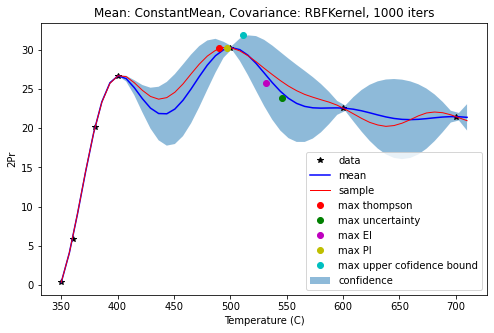

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

# mean
ax.plot(train_x, train_y, 'k*', label='data')
ax.plot(test_x, obs.mean.numpy(), 'b', label='mean')
lower, upper = obs.confidence_region()
ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='confidence')

# grab and plot metrics
ei = EI(obs)
pi = PI(obs)
max_var_i = np.argmax(obs.variance).item()
max_ei_i = np.argmax(ei).item()
max_ucb_i = np.argmax(upper)
max_pi_i = np.argmax(pi).item()
samp = obs.sample()
thomp_i = np.argmax(samp)

ax.plot(test_x, samp, 'r', lw=1, label='sample')
ax.plot(test_raw_x[thomp_i], samp[thomp_i], 'ro', label='max thompson')

ax.plot(test_raw_x[max_var_i], obs.mean[max_var_i], 'go', label='max uncertainty')
ax.plot(test_raw_x[max_ei_i], obs.mean[max_ei_i], 'mo', label='max EI')
ax.plot(test_raw_x[max_pi_i], obs.mean[max_pi_i], 'yo', label='max PI')
ax.plot(test_raw_x[max_ucb_i], upper[max_ucb_i], 'co', label='max upper cofidence bound')

ax.legend()
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('2Pr')
# ax.set_title(f'Mean: {model.mean_module._get_name()}, Covariance: {model.covar_module.base_kernel._get_name()}, {training_iter} iters')

# 

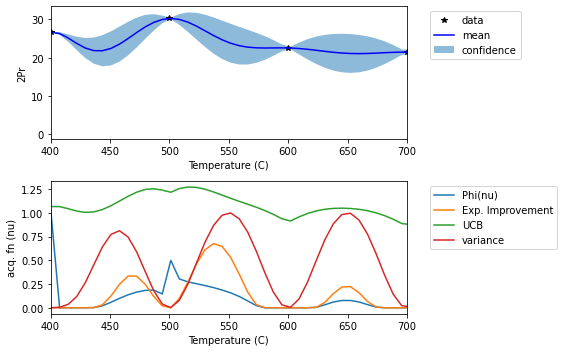

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(8,5))

# 2Pr vs T plot
ax[0].plot(train_x, train_y, 'k*', label='data')
ax[0].plot(test_x, obs.mean.numpy(), 'b', label='mean')
lower, upper = obs.confidence_region()
ax[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='confidence')
ax[0].legend(bbox_to_anchor=(1.05, 1))
ax[0].set_xlabel('Temperature (C)')
ax[0].set_xlim(400,700)

ax[0].set_ylabel('2Pr')

# plot acquisition function 
nu = NU(obs)
ax[1].plot(test_x, scipy.stats.norm.cdf(nu), label='Phi(nu)')
ax[1].plot(test_x, ei, label='Exp. Improvement')
ax[1].plot(test_x, upper/25, label='UCB')
ax[1].plot(test_x, obs.variance/obs.variance.max(), label='variance')
# ax[1].plot(test_x[np.argmax(nu)], nu[np.argmax(nu)], 'r+', label='maxima')
ax[1].set_xlabel('Temperature (C)')
ax[1].set_ylabel('acq. fn (nu)')
ax[1].set_xlim(400,700)
ax[1].legend(bbox_to_anchor=(1.05, 1))

fig.tight_layout()

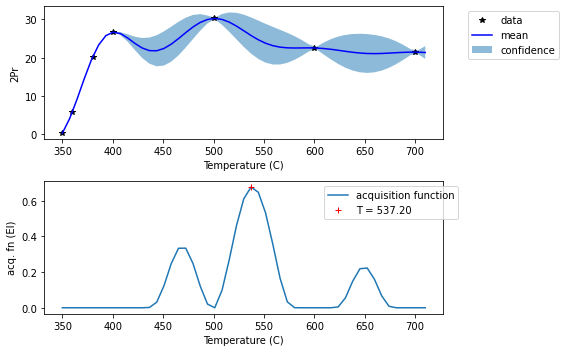

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(8,5))

# 2Pr vs T plot
ax[0].plot(train_x, train_y, 'k*', label='data')
ax[0].plot(test_x, obs.mean.numpy(), 'b', label='mean')
lower, upper = obs.confidence_region()
ax[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='confidence')
ax[0].legend(bbox_to_anchor=(1.05, 1))
ax[0].set_xlabel('Temperature (C)')
ax[0].set_ylabel('2Pr')

# plot acquisition function 
ei = EI(obs)
max_i = np.argmax(ei)
ax[1].plot(test_x, ei, label='acquisition function')
ax[1].plot(test_x[max_i], ei[max_i], 'r+', label=f'T = {test_x[max_i]:.2f}')
ax[1].set_xlabel('Temperature (C)')
ax[1].set_ylabel('acq. fn (EI)')
ax[1].legend(bbox_to_anchor=(1.05, 1))

fig.tight_layout()

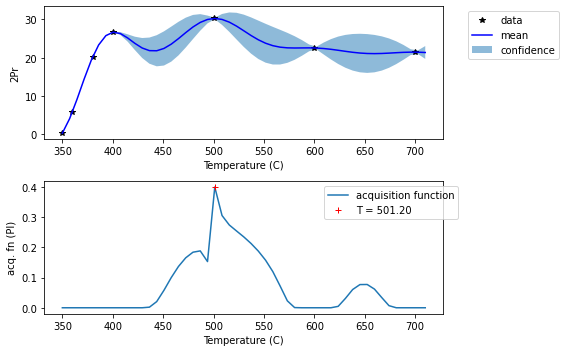

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(8,5))

# 2Pr vs T plot
ax[0].plot(train_x, train_y, 'k*', label='data')
ax[0].plot(test_x, obs.mean.numpy(), 'b', label='mean')
lower, upper = obs.confidence_region()
ax[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='confidence')
ax[0].legend(bbox_to_anchor=(1.05, 1))
ax[0].set_xlabel('Temperature (C)')
ax[0].set_ylabel('2Pr')

# plot acquisition function 
pi = PI(obs)
ax[1].plot(test_x, pi, label='acquisition function')
ax[1].plot(test_x[np.argmax(pi)], pi[np.argmax(pi)], 'r+', label=f'T = {test_x[np.argmax(pi)]:.2f}')
ax[1].set_xlabel('Temperature (C)')
ax[1].set_ylabel('acq. fn (PI)')
ax[1].legend(bbox_to_anchor=(1.05, 1))

fig.tight_layout()

In [16]:
list(model.named_parameters())

[('mean_module.constant',
  Parameter containing:
  tensor([19.7655], requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(8.0645, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[33.0165]], requires_grad=True))]

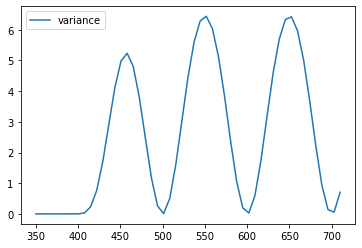

In [17]:
plt.plot(test_x, obs.variance, label='variance')
plt.legend()

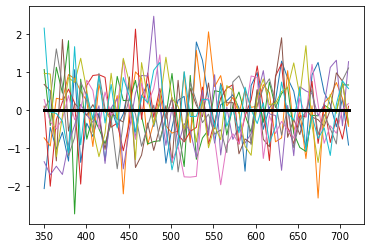

In [28]:
# draw samples from posterior
plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='confidence')
for i in range(10):
    plt.plot(test_x, obs.sample(), lw=1)

plt.plot(test_x, obs.mean, 'k', lw=3)



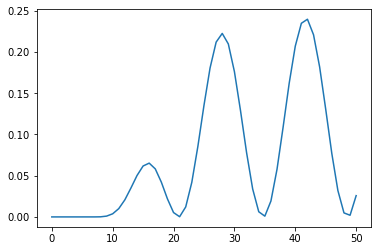

In [10]:
plt.plot(obs.variance)

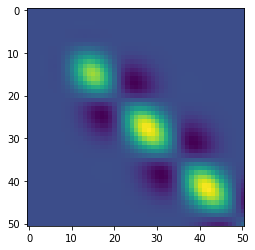

In [53]:
plt.imshow(obs.covariance_matrix)